In [1]:
import scanpy as sc
import os
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as ad

import scvi
import torch
from scvi.external import CellAssign

import matplotlib
import matplotlib.pyplot as plt

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dirs = [
    "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127766_NOA1/",
    "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127767_NOA2/",
    "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127768_NOA3/",
    "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127769_OA1/",
    "/faststorage/project/projectsInBioinformatics/data/GSE202647/GSM6127770_OA2/"
            ]

In [3]:
a = sc.read_10x_mtx(data_dirs[0])
a.var_names_make_unique()

b = sc.read_10x_mtx(data_dirs[1])
b.var_names_make_unique()

c = sc.read_10x_mtx(data_dirs[2])
c.var_names_make_unique()

d = sc.read_10x_mtx(data_dirs[3])
d.var_names_make_unique()

e = sc.read_10x_mtx(data_dirs[4])
e.var_names_make_unique()

adatas = {'NOA1': a, 'NOA2': b, 'NOA3': c, 'OA1': d, 'OA2': e}

adata = ad.concat(adatas, label = "dataset")
adata.obs_names_make_unique

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 33683 × 27984
    obs: 'dataset'>

In [4]:
adata


AnnData object with n_obs × n_vars = 33683 × 27984
    obs: 'dataset'

In [5]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.layers["raw_counts"] = adata.X.copy()

In [6]:
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


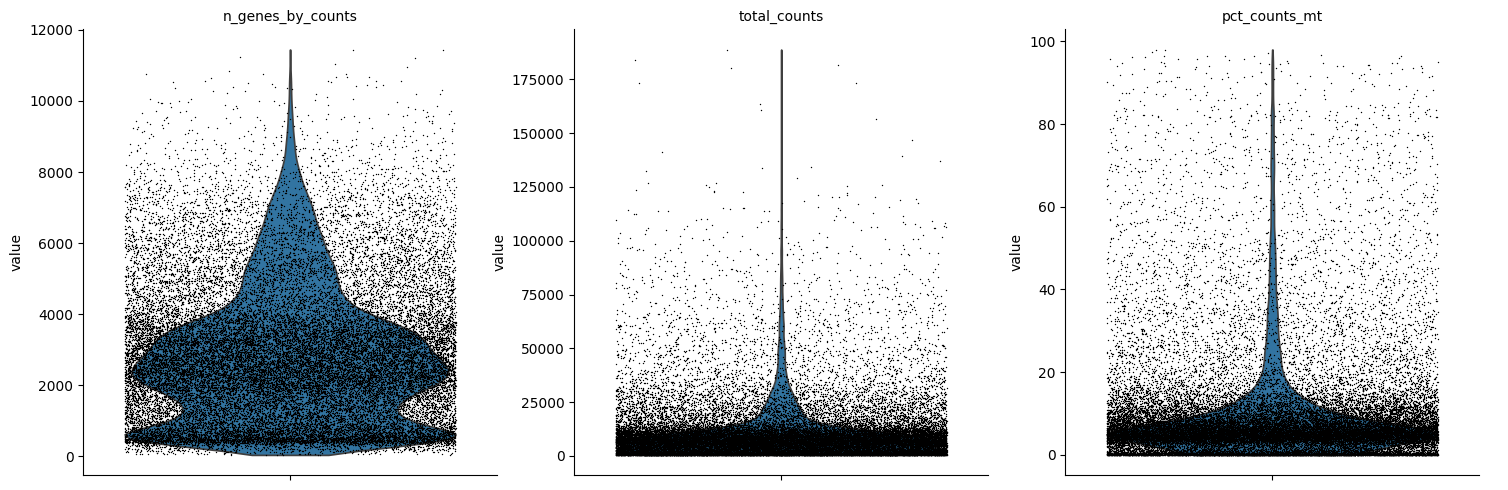

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0.4, multi_panel = True)


In [8]:
sc.pp.filter_genes(adata, min_cells = 3, inplace = True)

sc.pp.filter_cells(adata, min_genes = 200, inplace = True)
sc.pp.filter_cells(adata, max_genes= 8000, inplace = True)

adata = adata[adata.obs['pct_counts_mt'] < 20].copy()

adata = adata[adata.obs['total_counts'] < 75000].copy()

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


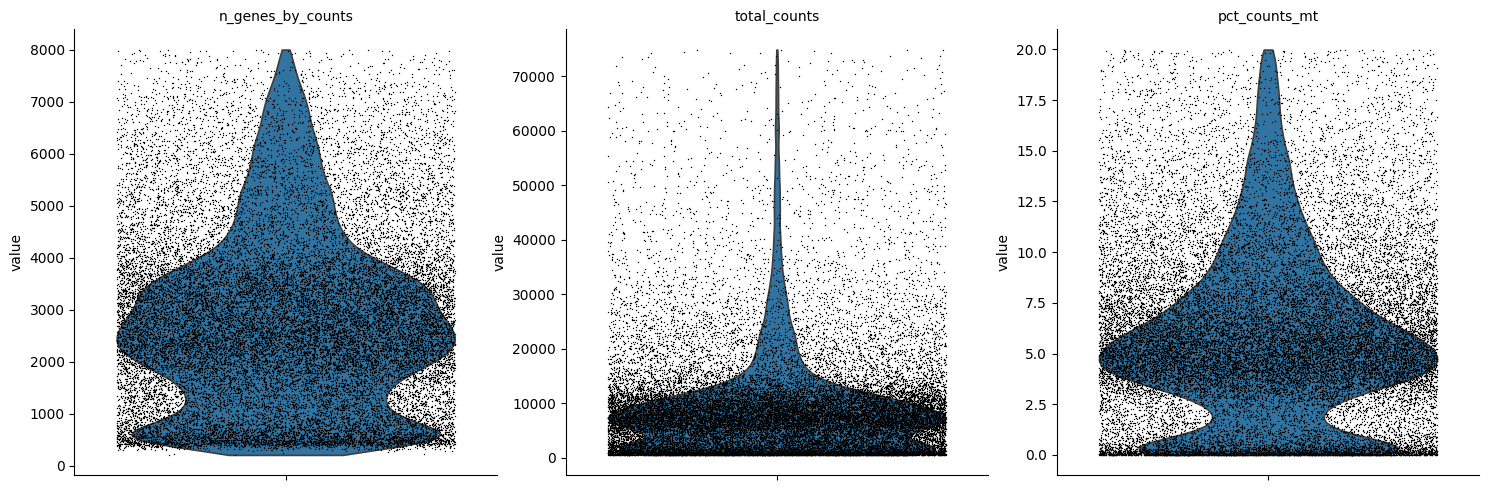

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter = 0.4, multi_panel = True)


In [10]:
adata.layers["filter_counts"] = adata.X.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, min_mean = 0.02, max_mean = 4, min_disp = 0.5)

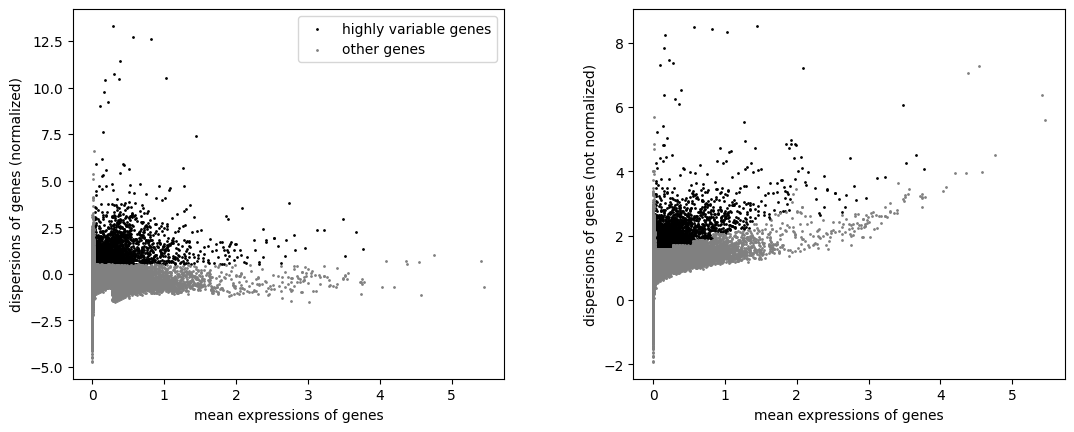

In [13]:
sc.pl.highly_variable_genes(adata)

In [14]:
np.sum(adata.var.highly_variable)

np.int64(4033)

In [15]:
sc.pp.scale(adata, max_value = 10)

/home/jool/miniforge3/envs/torch/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [16]:
adata.layers["normalised"] = adata.X.copy()

In [17]:
sc.tl.pca(adata, svd_solver = 'arpack')

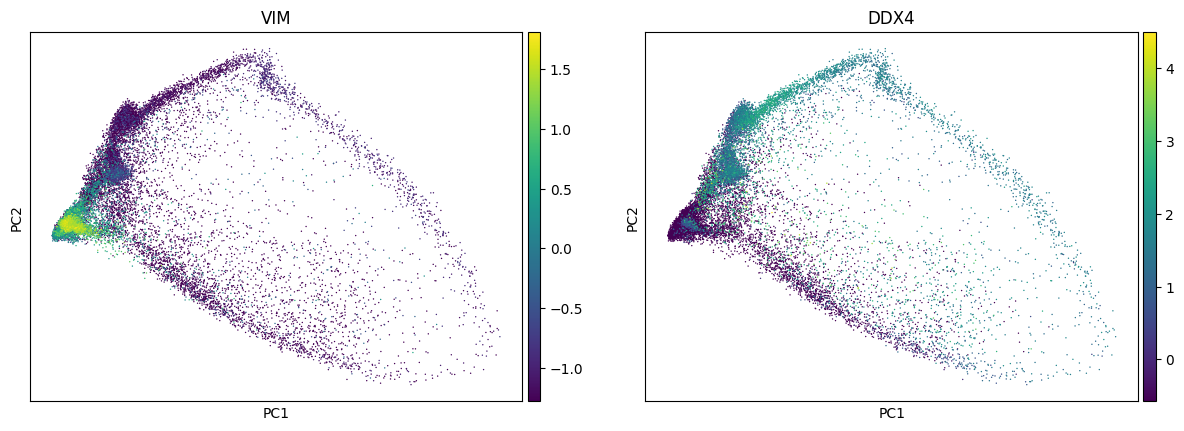

In [18]:
markers = ['VIM', 'DDX4'] #VIM: somatic cells, DDX4: spermatogonia, spermatocytes, spermatids
sc.pl.pca(adata, color = markers)

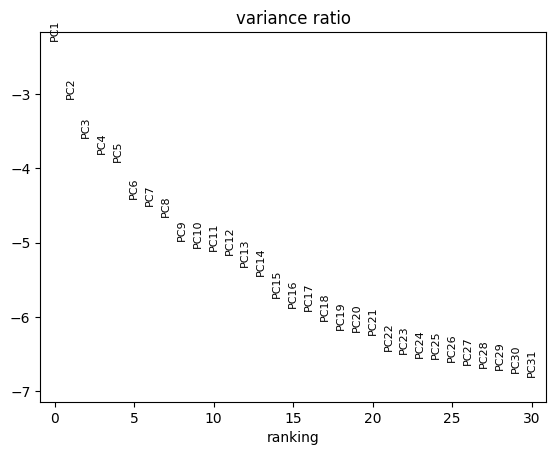

In [19]:
sc.pl.pca_variance_ratio(adata, log = True)

In [20]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 25)

In [21]:
sc.tl.leiden(adata, resolution = 0.5)

/tmp/10341642/ipykernel_1060558/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [22]:
sc.tl.umap(adata, spread = 1, min_dist = 0.5, random_state = 1)

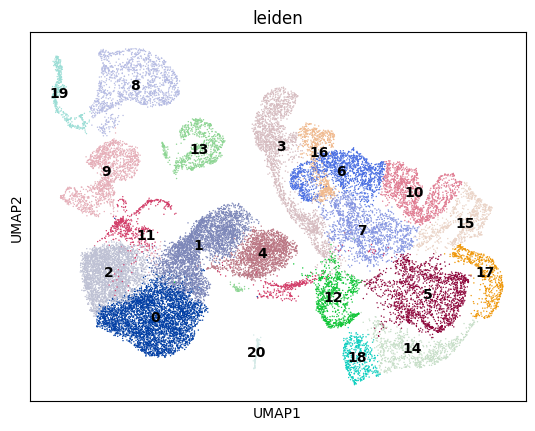

In [23]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 't-test')

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

In [25]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
ranked_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})
ranked_genes.head(10)

0_n  0_p      1_n  1_p     2_n  2_p       3_n  3_p     4_n  4_p  \
0       DCN  0.0    PTGDS  0.0     DCN  0.0     HMGA1  0.0   ACTA2  0.0   
1       VIM  0.0     APOE  0.0     FTL  0.0    DNAJB6  0.0    FHL2  0.0   
2    IGFBP7  0.0    NR2F2  0.0   ADIRF  0.0    LYPLA1  0.0    MYL9  0.0   
3       CFD  0.0   IGFBP7  0.0  IGFBP6  0.0    PAGE2B  0.0  IGFBP7  0.0   
4  SERPINF1  0.0    TSHZ2  0.0   ITM2B  0.0    ELAVL2  0.0   PTGDS  0.0   
5      CD63  0.0    CALD1  0.0   GSTM5  0.0     RPS12  0.0    TPM2  0.0   
6      CD81  0.0      DCN  0.0   PTGDS  0.0  PAFAH1B3  0.0     ENG  0.0   
7     RPL10  0.0  COL15A1  0.0    APOE  0.0      RPSA  0.0    MYL6  0.0   
8     ITM2B  0.0    ITM2B  0.0   RPL10  0.0     EGFL7  0.0   DPEP1  0.0   
9       C1S  0.0    NEAT1  0.0  IGFBP7  0.0    PCSK1N  0.0   SMOC2  0.0   

         5_n  5_p      6_n  6_p        7_n            7_p       8_n  8_p  \
0      HMGB4  0.0    SYCP3  0.0       PRM2  4.916869e-236      CD74  0.0   
1       PRM1  0.0     SMC3  0.0       PRM1  5.365311e-235   HLA-DRA  0.0   
2       PRM2  0.0    TOP2A  0.0      TOP2A  8.016277e-218       B2M  0.0   
3      NUPR2  0.0    SMC1B  0.0      SYCP3  5.634789e-217    TMSB4X  0.0   
4       TNP1  0.0   ZCWPW1  0.0    C5orf58  5.232739e-179  HLA-DRB1  0.0   
5  LINC00467  0.0     KNL1  0.0  HIST1H2AA  1.375717e-165  HLA-DPA1  0.0   
6    FAM229A  0.0   TEX101  0.0      SYCP1  2.537632e-153    TYROBP  0.0   
7   CATSPERZ  0.0  C5orf47  0.0      SMC1B  1.103901e-148       FTL  0.0   
8      DKKL1  0.0  HORMAD1  0.0   HSP90AA1  5.430355e-150  HLA-DPB1  0.0   
9  C20orf144  0.0    SCML1  0.0    HORMAD1  9.388458e-148      C1QA  0.0   

       9_n  9_p     10_n  10_p    11_n          11_p     12_n           12_p  \
0     MYL9  0.0  C5orf58   0.0    PRM1  2.582142e-98  DEFB119  1.975734e-280   
1    TAGLN  0.0  HORMAD1   0.0    PRM2  1.006797e-94    FATE1  2.691310e-265   
2    CALD1  0.0   SPINT2   0.0    TNP1  6.841019e-73   CITED1  2.428688e-252   
3     TPM2  0.0   KRBOX1   0.0   PTGDS  1.808854e-65   TMSB10  1.882522e-260   
4    ACTA2  0.0    CRNDE   0.0    APOE  1.814140e-45      CLU  2.574528e-231   
5   IGFBP7  0.0     RCN2   0.0  TMSB4X  1.434375e-37    APOA1  4.216724e-215   
6    ADIRF  0.0    STMN1   0.0     FTL  5.672665e-36    GSTA1  5.186378e-204   
7  SPARCL1  0.0    TEX30   0.0   INSL3  1.403569e-29     COPE  6.259971e-194   
8     TPM1  0.0    SYCP3   0.0   RPL10  1.390684e-28   RNASE1  1.831496e-193   
9     PTMA  0.0  SPATA22   0.0   CALB2  2.803367e-28    HMGN5  2.056219e-189   

     13_n           13_p       14_n  14_p        15_n  15_p    16_n  16_p  \
0   HLA-E   0.000000e+00       PRM2   0.0       CMTM2   0.0   HERC5   0.0   
1     B2M   0.000000e+00     CRISP2   0.0       TSACC   0.0   TKTL1   0.0   
2   HLA-B   0.000000e+00      LELP1   0.0      ANKRD7   0.0    SMC3   0.0   
3   GNG11   0.000000e+00       PRM1   0.0      SPINK2   0.0    NASP   0.0   
4     A2M   0.000000e+00       SMCP   0.0  AL133499.1   0.0   PRAME   0.0   
5   HLA-C   0.000000e+00      TSACC   0.0        LDHC   0.0   YWHAE   0.0   
6  TMSB4X   0.000000e+00      NUPR2   0.0    CATSPERZ   0.0    PTMA   0.0   
7     VWF  9.887632e-316  LINC00467   0.0      BOD1L2   0.0   BUD23   0.0   
8  TMSB10   0.000000e+00     SH3RF2   0.0         UBB   0.0   CCT6A   0.0   
9   TXNIP   0.000000e+00      HMGB4   0.0        YBX3   0.0  ANP32B   0.0   

        17_n  17_p     18_n           18_p    19_n           19_p     20_n  \
0      CMTM2   0.0   CRISP2   0.000000e+00     B2M   0.000000e+00    GPM6B   
1      CDKN3   0.0    NUPR2   0.000000e+00   RPL10  4.373270e-245    S100B   
2     ROPN1L   0.0     PRM2   0.000000e+00   HLA-B  9.266819e-182      CD9   
3   CATSPERZ   0.0  DCUN1D1   0.000000e+00    CYBA  4.758831e-176    PMP22   
4     BOD1L2   0.0     SMCP   0.000000e+00   RPL41  2.790309e-176      VIM   
5      TSACC   0.0   BOD1L2  9.106373e-312   HLA-C  2.500201e-163   S100A6   
6  LINC00467   0.0    LELP1  2.494910e-297  S100A4  1.816387e-153    C

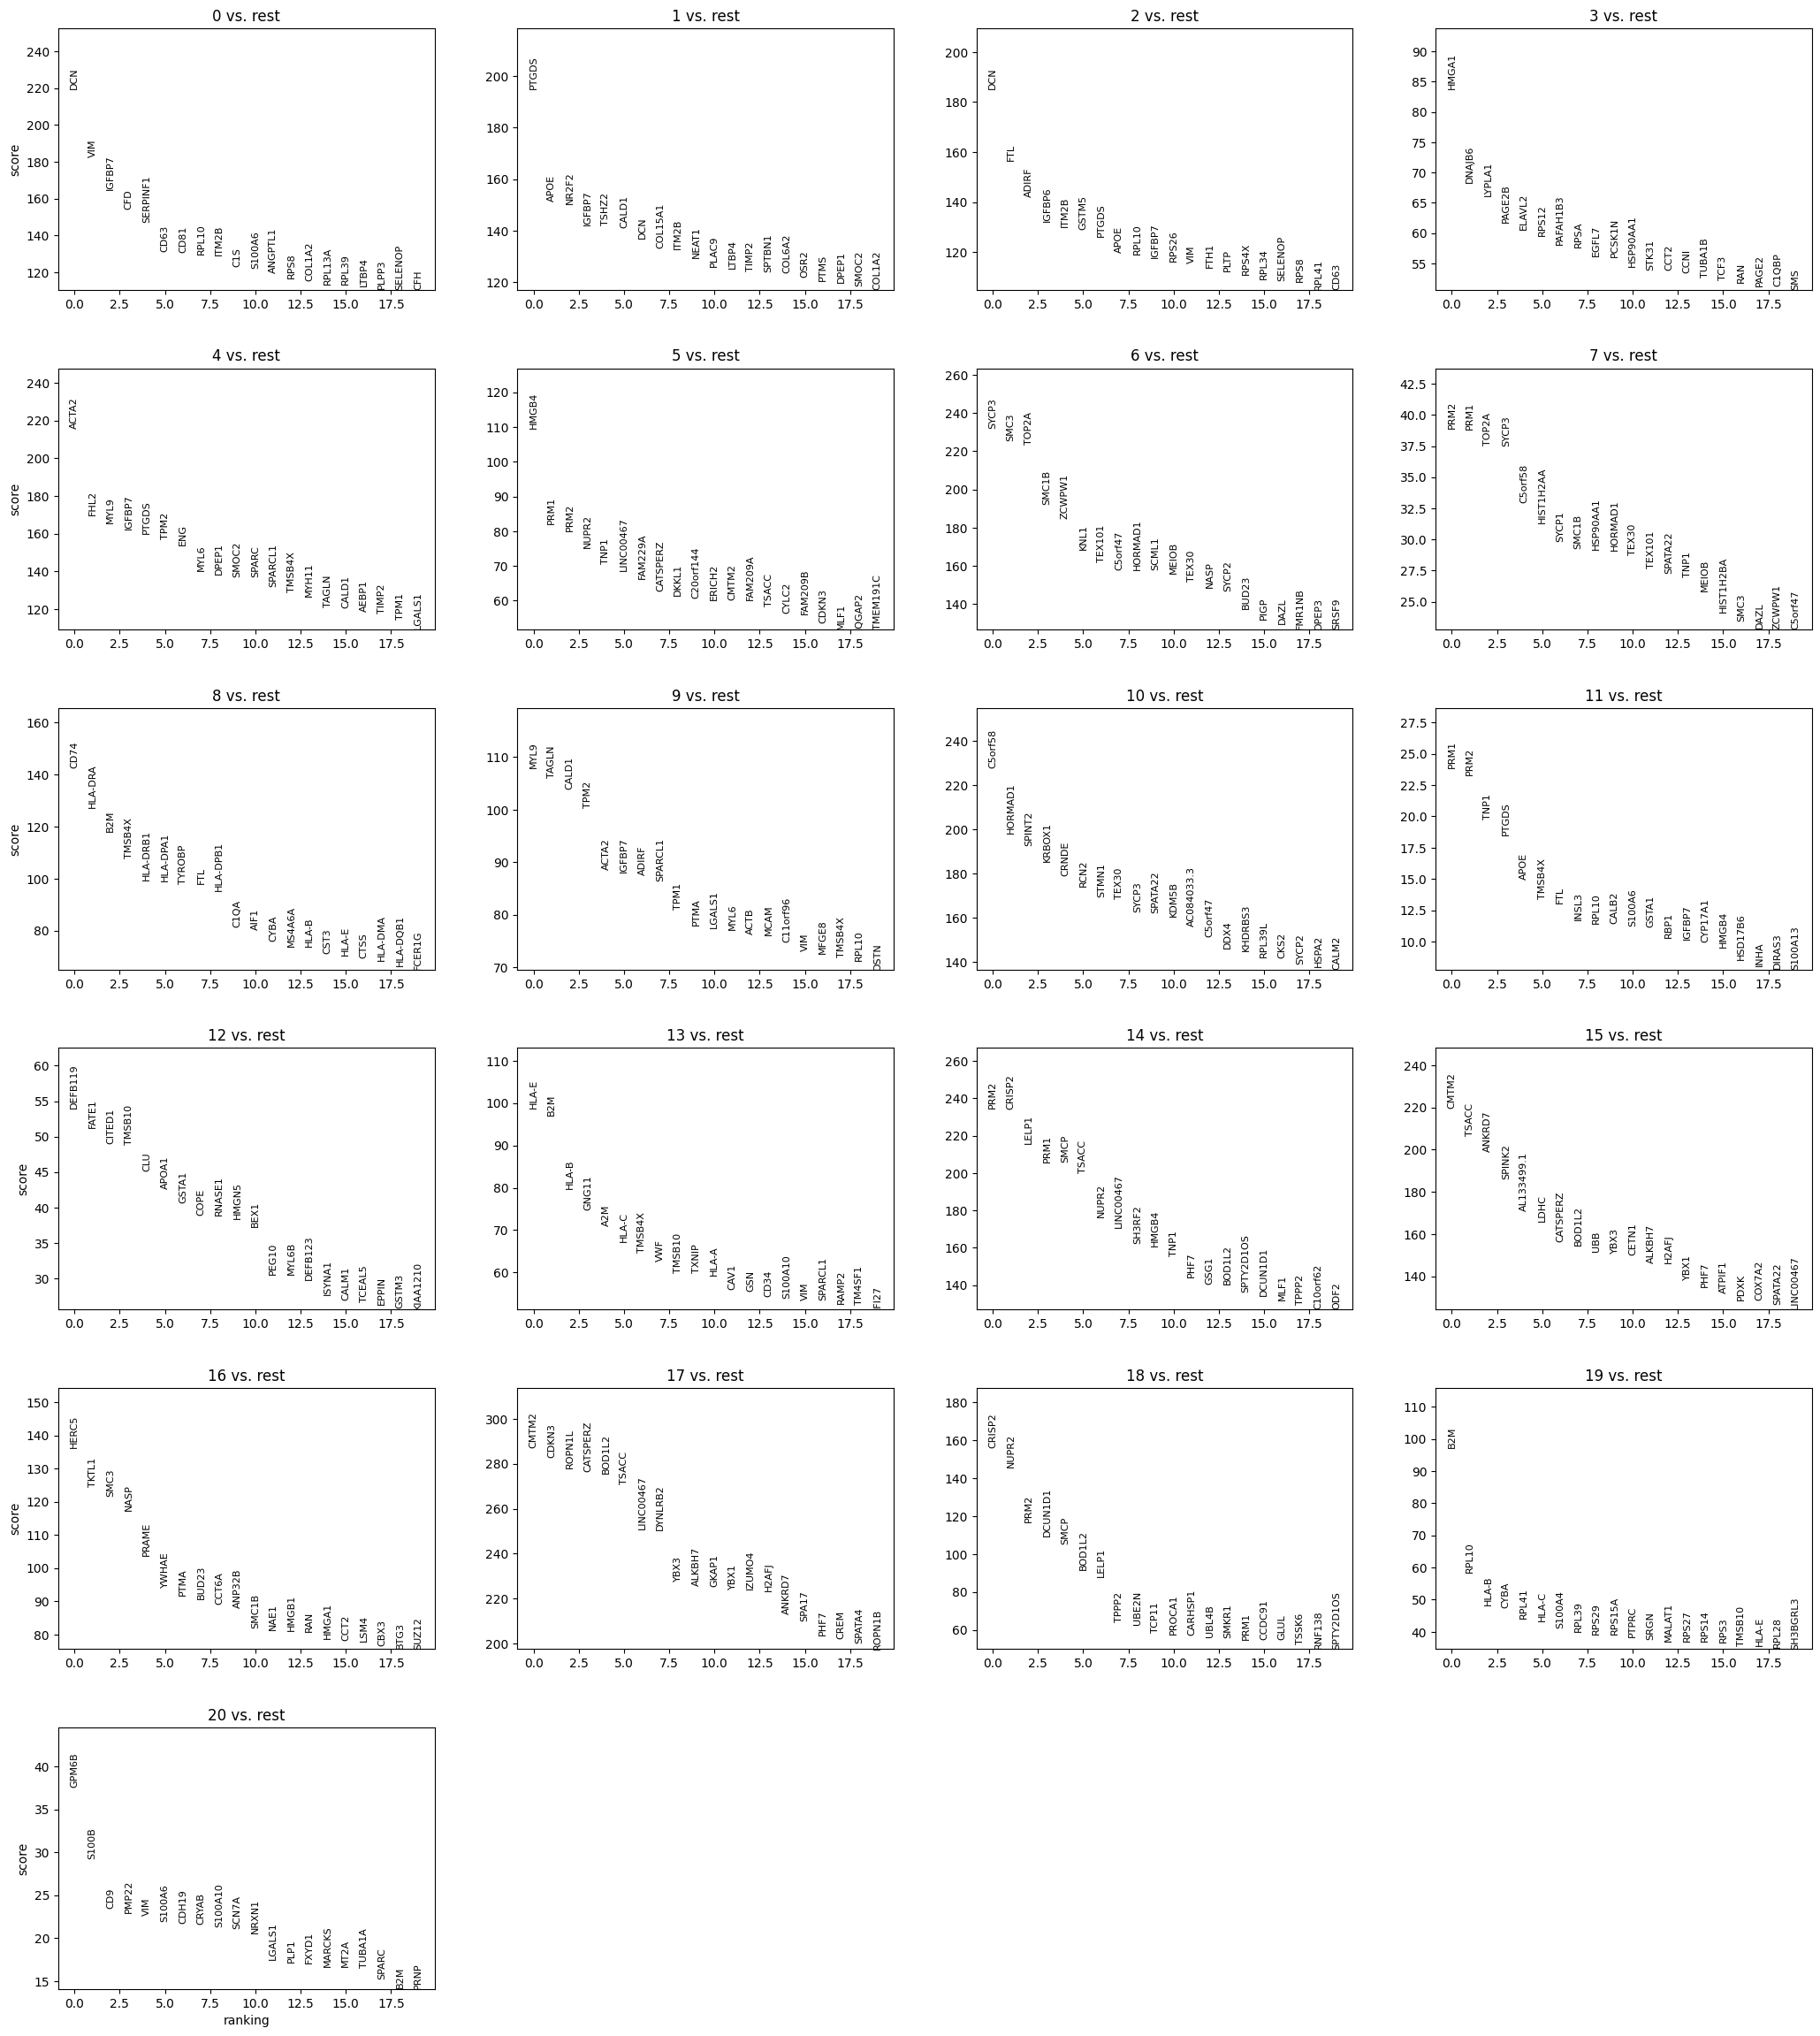

In [26]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In [27]:
adata = adata[~adata.obs.leiden.isin(["19", "20"])] #19 ribosomal markers, 20 very low scores probably indicating multiple celltypes. Guessing immune cells


In [28]:
adata

View of AnnData object with n_obs × n_vars = 28750 × 25464
    obs: 'dataset', 'size_factor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'filter_counts', 'normalised'
    obsp: 'distances', 'connectivities'

In [29]:
marker_genes = {
    #Overview
    "Sertoli": ["SOX9","GATA1","ACSL4","WT1","GAS6","VIM","CD99", "APOA1"],
    "Leydig": ["CFD","IGF1","IGFBP5","INSL3"], 
    "Myoid": ["MYH11", "ACTA2"],
    "Macrophage": ["CD68", "CD163", "MSR1", "CD14"], 
    "Endothelial": ["VWF", "SOX17"],
    "B": ["CD52"],
    "Mast": ["TPSB2"],
    "T": ["CCL5"],
    "Plasma": ["IGLC2"],
    "PMC": ["DPEP1"],
    "Schwann": ["S100B"],
    "Smooth muscle": ["TAGLN"],
    #"Germ": ["CRNDE"]

    #Germline specific stages, SPG: Spermatogonia, SC: Spermatocytes, SD: Spermatid.
    "SSC1.SPG": ["ID4", "UTF1", "TWIST1", "KRT18", "AES", "ENHO", "C19orf84", "SIX1", "PIWIL4"], #ENH0
    "SSC2.SPG":["ASB9", "L1TD1", "NANOS3", "FAM25G", "CITED2"],
    "Diffing.SPG": ["MKI67", "ACTL8", "KLHL15", "DMRT1", "PABPC4"],
    "Diffed.SPG": ["SSX3", "TEX19", "PNMA6E", "PEG10", "TKTL1", "BEND2"],
    "PreLeptotene.SC": ["DPH7", "PRDM9", "PRAP1", "KIF1A", "MAGEA9B", "FAM9C", "ATP6AP1", "OTUD6A", "CCNB3"], 
    "Leptotene.Zygotene.SC": ["LINC00668", "AP000350.6", "LINC01120", "AL138889.1", "LINC00865", "C18orf63"], 
    "Pachytene.SC": ["PCDHB6", "POM121L12", "POM121L2", "C9orf57", "AL133279.3", "AC093326.2", "AL353581.1", "PCDHB5", "PCDHB2", "AC135012.2", "MNS1", "CCDC42"],
    "Diplotene.SC": ["ART5", "KLB", "B3GALT4", "ELMO3", "RTN4RL2", "AC073263.2", "LINC00588", "WNT6", "LINC01309", "AL121936.1", "KRT72", "LDHC"],
    "Early.Round.SD": ["FAM24A","SPACA1","LINC01351","ABRA","LINC00703","LINC02502","PPP1R27","H1F0","TPRG1","LRRC39","C1orf87","TMIGD3"],
    "Round.SD": ["TNP2","LINC02314","LINC01921","PRSS37","FBXO39","LINC02400","DHRS3","FAM205C","CXorf65","SCP2D1","LINC01548","CCDC179","AC010255.3","SPEM3"], #AC113189.2 -> SPEM3
    "Elongated.SD": ["TSSK6","CABS1","SPATA3","CCDC196","TSPAN16","PHOSPHO1","SPEM2","TEX44","LRRD1","SPEM1","GLUL"] #FLJ40194
    
    # "Undiff.Spermatogonia": ["PIWIL3","KHDRBS2","CALN1","FGFR3","SLC22A2","PIWIL4","NRG3", "CRNDE"],
    # "Diff.Spermatogonia": ["SDF2L1","HELLS","DMRT1", "SYCP3", "CRNDE"],
    # "Leptotene.SC": ["GPAT2","DMC1","SYCE1", "CRNDE"], 
    # "Zygotene.SC": ["SYCP1", "CRNDE"], 
    # "Pachytene.SC": ["PIWIL1","NME5","ADAM2","PROK2", "CRNDE"],
    # "Early.Round.SD": ["AURKA","TBPL1","SNRPC", "CRNDE"],
    # "Round.SD": ["LYZL6","PSD3","SLC16A7","TBC1D21","TMEM144","ACRV1","FTMT","LYZL4","SPATA9","TULP2","HMGB4","ACTL7A", "TEX29", "SUN5", "CRNDE"],
    # "Elongated.SD": ["GABBR2","NRBP1","PRM1","PRM2","TNP1","BAG1", "CRNDE"]
    }

In [30]:
def write_celltype_markers(marker_genes):

    h = list(marker_genes.keys())
    h.insert(0, "Gene")

    with open("celltype_markers.csv", "w") as f:
        f.write(",".join(h) + "\n")
        for type in marker_genes:
            for gene in marker_genes[type]:
                r = [gene] + ["1" if gene in marker_genes[t] else "0" for t in marker_genes]
                f.write(",".join(r) + "\n")

In [31]:
write_celltype_markers(marker_genes=marker_genes)

In [32]:
def marker_score(markers_dict, adata, N_samples=100, random_seed=42): #Taken from NGS 2025 course pythonScript.py
    np.random.seed(random_seed)
    markers_list = []
    N_genes = adata.shape[1]
    random_genes = np.unique( np.random.randint(low=0, high=N_genes, size=N_samples) )
    gene_names = adata.var_names[random_genes]
    for i in markers_dict:
        markers_list.append(f'{i}_score')
        adata.obs[f'{i}_score'] = np.array(np.mean(adata[:,markers_dict[i]].X,1) - np.mean(adata[:,gene_names].X,(0,1)))
    return markers_list, adata

In [33]:
marker_scores, adata = marker_score(marker_genes, adata)

/tmp/10341642/ipykernel_1060558/1646262721.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f'{i}_score'] = np.array(np.mean(adata[:,markers_dict[i]].X,1) - np.mean(adata[:,gene_names].X,(0,1)))
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


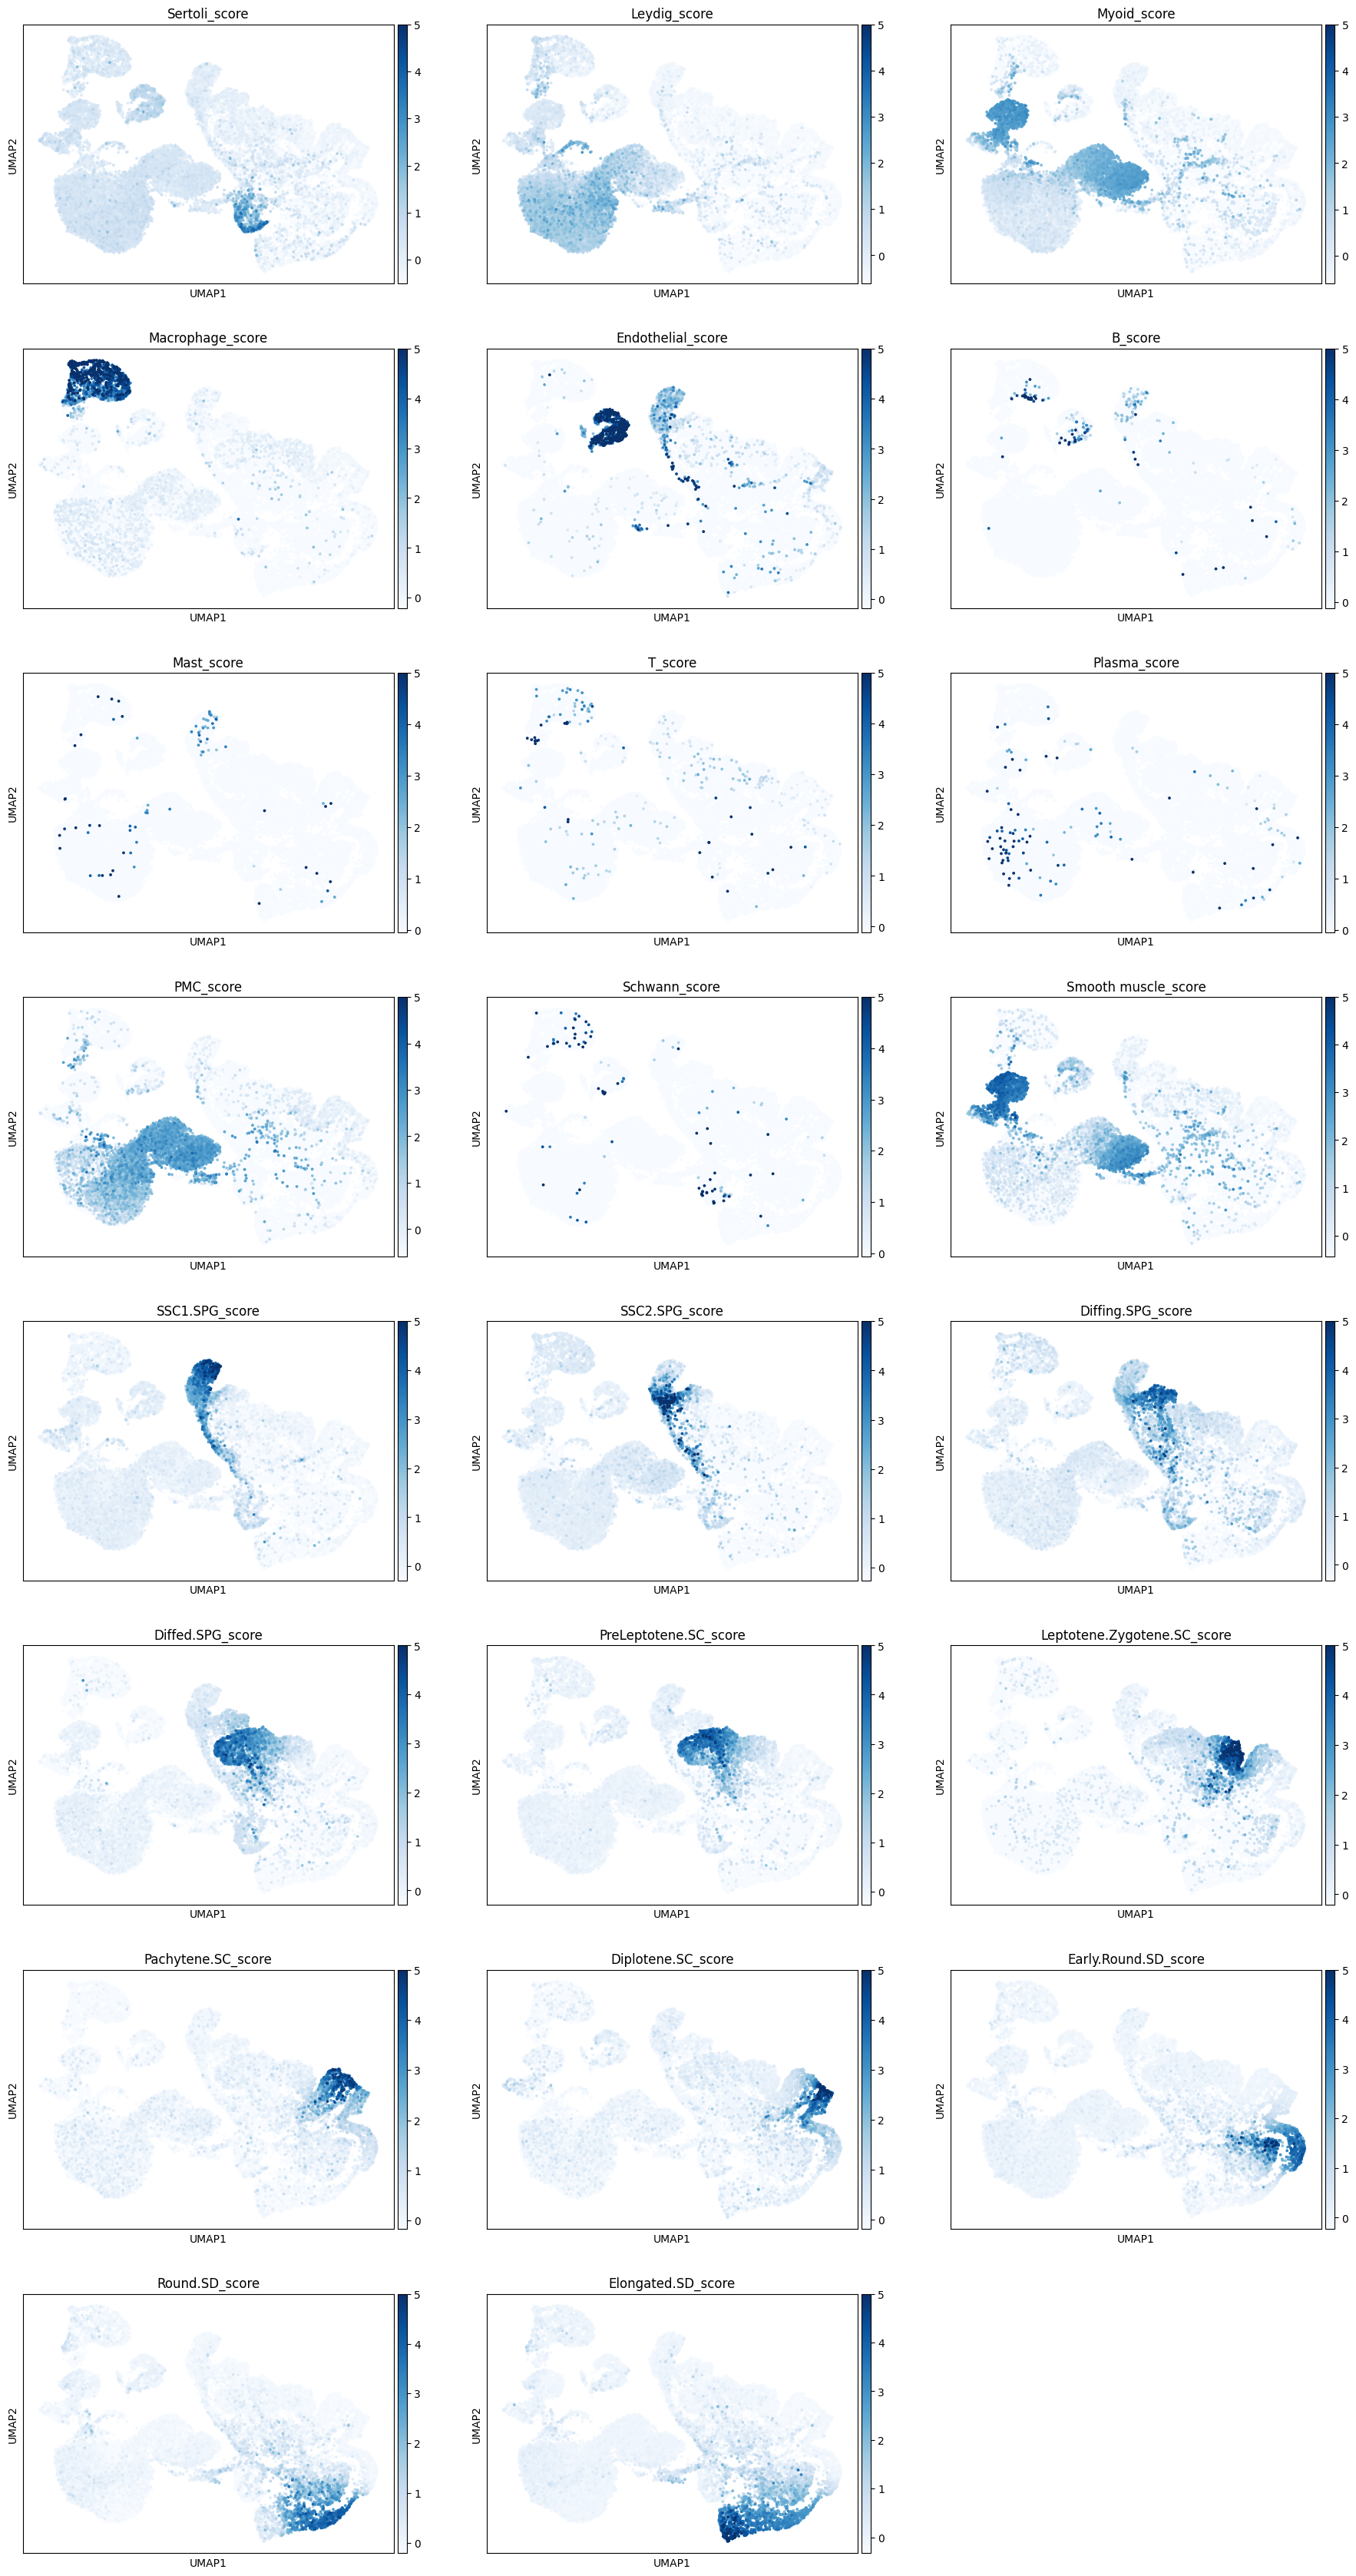

In [34]:
sc.pl.umap(adata, color=marker_scores, components = ['1,2'], ncols = 3, vmax = 5, s=30, cmap = 'Blues')

categories: 0, 1, 2, etc.
var_group_labels: Sertoli, Leydig, Myoid, etc.


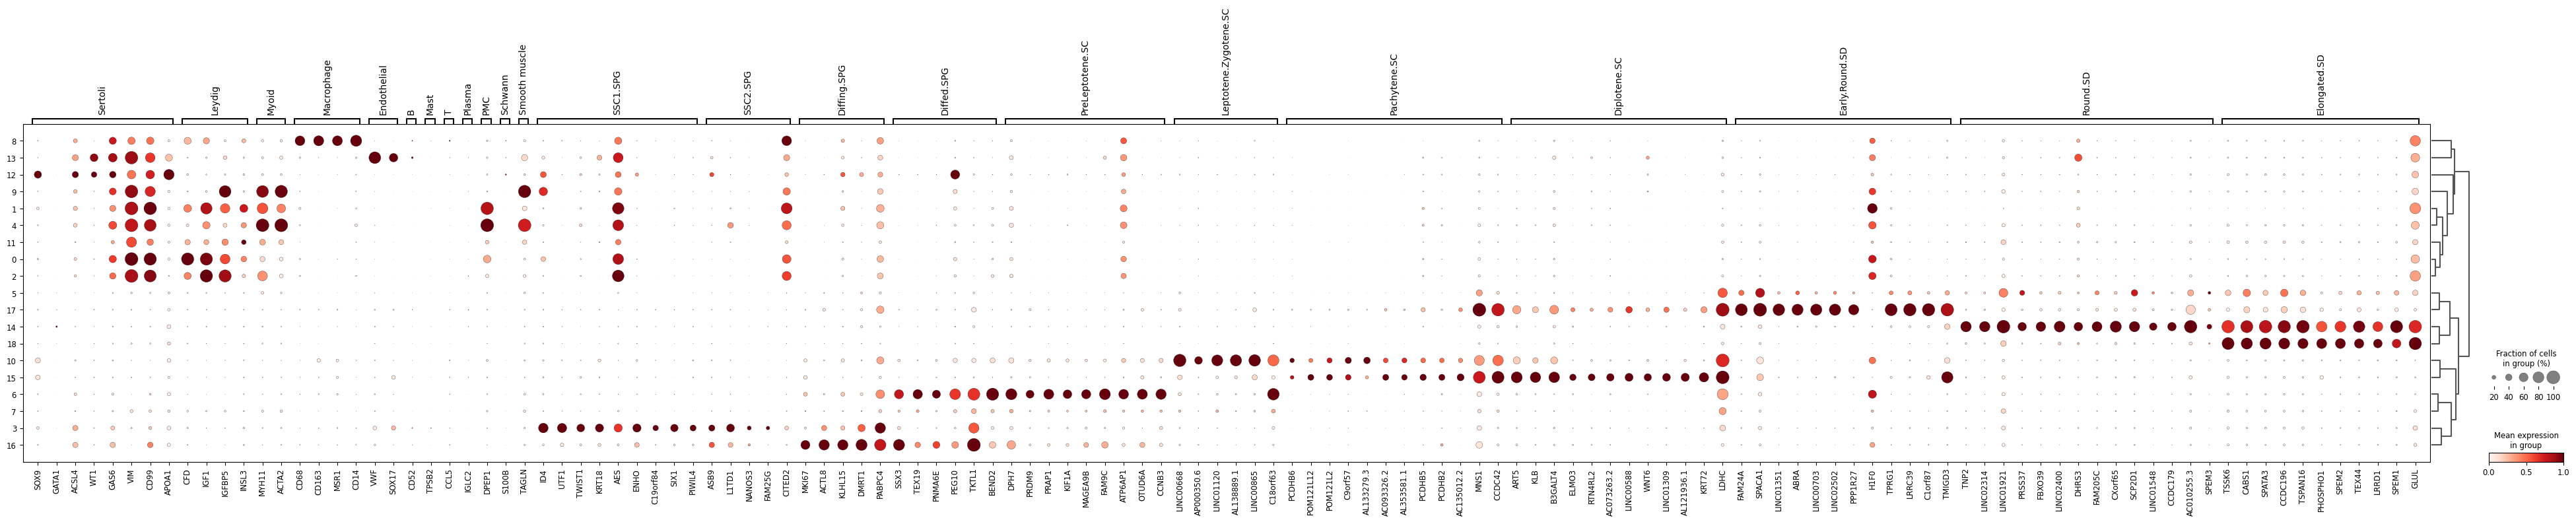

In [35]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    var_names = marker_genes,
    standard_scale = 'var'
)

In [36]:
def clustersByScores(adata, markers_scores, leidenClusters): #from NGS 2025 pythonScripts
    clusters = pd.Categorical(leidenClusters)
    scoresTable = adata.obs[markers_scores]
    clusterUnique = np.unique(leidenClusters)
    newNames = pd.Series(index=leidenClusters)
    for CLST in clusterUnique:
        meanScores = np.mean( scoresTable.loc[leidenClusters==CLST,:], 0)
        newId = meanScores.index[ np.argmax(meanScores) ].split('_')[0]
        newNames[CLST] = newId
    return(pd.Categorical(newNames))

In [37]:
adata.obs['celltype_leiden'] = clustersByScores(adata, marker_scores, adata.obs["leiden"])
adata.obs.celltype_leiden = adata.obs.celltype_leiden.astype("category")

/tmp/10341642/ipykernel_1060558/1796372152.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Leydig' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  newNames[CLST] = newId


In [38]:
#sc.pl.umap(adata, color = ["celltype_leiden"], legend_loc = "on data", components = ['1,2'])

In [38]:
adata.write("../../results/combined_rna.h5ad")

# Cell annotation using CellAssign

In [39]:
celltype_markers = pd.read_csv("/faststorage/project/projectsInBioinformatics/workspaces/johan/PIB-johan-olesen/Notebooks/celltype_markers.csv", index_col = 0)
scvi.settings.seed = 0
torch.set_float32_matmul_precision("high")

[rank: 0] Seed set to 0


In [40]:
adata.X = adata.layers["raw_counts"]
bdata = adata[:, celltype_markers.index].copy()

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [41]:
bdata = bdata[bdata.X.sum(axis=1) > 0, :]
bdata = bdata[:, bdata.X.sum(axis=0) >0]

celltype_markers = celltype_markers.loc[celltype_markers.index.intersection(bdata.var_names)]
bdata = bdata[:, bdata.var_names.isin(celltype_markers.index)].copy()

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [42]:
CellAssign.setup_anndata(bdata, size_factor_key = "size_factor")

In [43]:
model = CellAssign(bdata, celltype_markers)

In [44]:
model.train(accelerator="cuda", max_epochs = 200)

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.13 /home/jool/miniforge3/envs/torch/lib/python3.13/ ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|█| 200/200 [01:06<00:00,  3.09it/s, v_num=1, train_loss=64.7

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█| 200/200 [01:06<00:00,  3.01it/s, v_num=1, train_loss=64.7


<Axes: xlabel='epoch'>

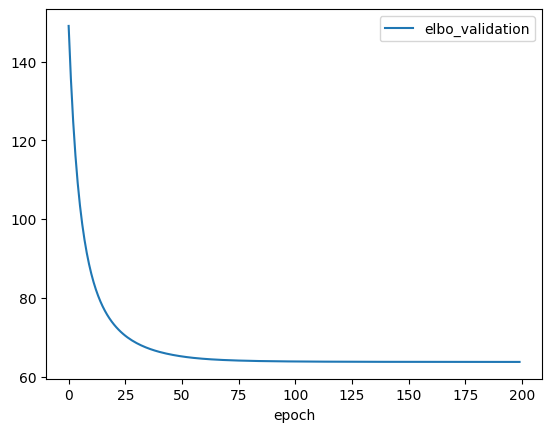

In [45]:
model.history["elbo_validation"].plot()

In [46]:
predictions = model.predict()
predictions.head()

Sertoli        Leydig         Myoid    Macrophage   Endothelial  \
0  2.206516e-10  1.263708e-08  2.869533e-08  6.441129e-10  9.930166e-09   
1  5.839655e-14  6.213869e-12  8.556570e-12  2.527089e-13  1.000368e-12   
2  1.301227e-04  4.574034e-03  5.602536e-03  7.260263e-04  1.172122e-03   
3  9.458474e-28  1.062724e-25  1.714737e-25  3.909497e-27  8.401554e-25   
4  7.277062e-05  3.731343e-01  6.256360e-01  1.170205e-04  3.488845e-04   

              B          Mast             T        Plasma           PMC  \
0  6.256329e-11  2.339211e-11  4.221246e-11  1.007862e-15  1.087512e-09   
1  2.295512e-14  1.261239e-14  1.610468e-14  6.328519e-22  3.112928e-13   
2  2.437287e-05  2.687170e-05  1.921606e-05  7.600530e-06  2.382071e-06   
3  3.715766e-28  1.687628e-28  2.547579e-28  2.253641e-35  5.839817e-27   
4  8.249102e-06  6.461520e-06  6.160547e-06  1.279346e-08  1.505540e-10   

        Schwann  Smooth muscle      SSC1.SPG      SSC2.SPG   Diffing.SPG  \
0  1.330781e-09   1.052734e-09  1.000000e+00  2.708275e-06  7.239368e-08   
1  4.290531e-13   3.251250e-14  4.354522e-14  6.216850e-14  3.947908e-12   
2  2.590277e-04   6.143884e-06  2.422804e-01  8.094686e-03  7.260163e-01   
3  7.492298e-27   5.631802e-27  1.000000e+00  4.640305e-27  2.670474e-26   
4  1.239202e-04   2.866620e-10  3.288247e-05  2.647407e-05  1.792386e-04   

     Diffed.SPG  PreLeptotene.SC  Leptotene.Zygotene.SC  Pachytene.SC  \
0  8.491158e-10     2.188663e-08           8.158145e-10  6.254801e-11   
1  6.971865e-08     1.000000e+00           1.938408e-12  4.165715e-14   
2  3.405130e-03     4.161847e-03           9.581920e-04  3.057710e-04   
3  9.615490e-28     1.631775e-25           4.128244e-27  4.318264e-28   
4  9.931129e-06     6.444071e-05           1.330129e-04  3.949744e-05   

   Diplotene.SC  Early.Round.SD      Round.SD  Elongated.SD  
0  3.440133e-11    8.061677e-12  9.309566e-12  7.826319e-13  
1  2.573630e-13    6.213078e-15  6.998484e-16  3.037740e-16  
2  2.694326e-04    1.404602e-04  1.816582e-03  2.423722e-06  
3  2.425840e-28    3.024633e-28  1.678255e-28  7.313900e-30  
4  4.121964e-05    4.680122e-06  1.444596e-05  6.298968e-07

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


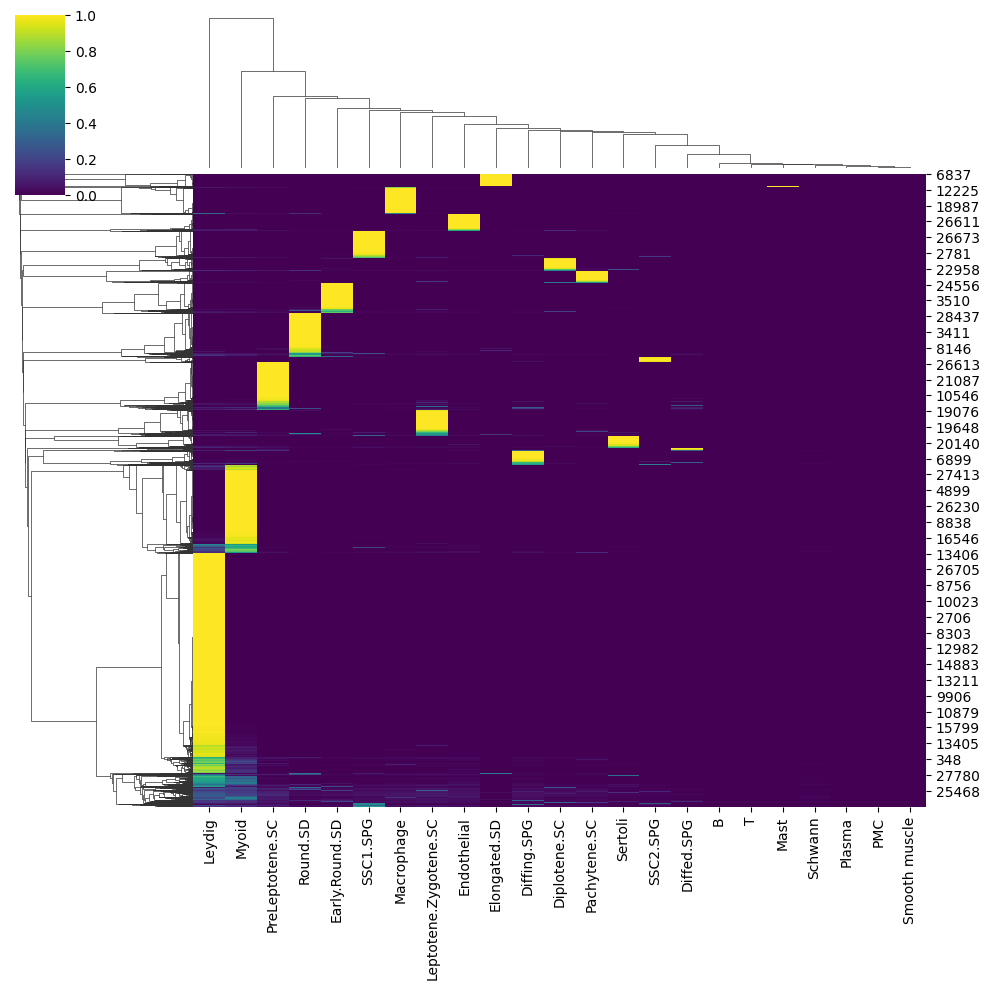

In [47]:
sns.clustermap(predictions, cmap = "viridis")

In [48]:
bdata.obs["celltype_CellAssign"] = predictions.idxmax(axis=1).values
bdata.obs.celltype_CellAssign = bdata.obs.celltype_CellAssign.astype("category")

In [49]:
marker_genes_cats = list(marker_genes.keys())
all_cats = pd.Index(marker_genes_cats)
bdata.obs["celltype_CellAssign"].cat.set_categories(all_cats)
bdata.obs["celltype_leiden"].cat.set_categories(all_cats)

#bdata.obs.celltype_CellAssign.cat.reorder_categories(marker_genes_cats)
#bdata.obs.celltype_leiden.cat.reorder_categories(marker_genes_cats)

palette = sc.pl.palettes.godsnot_102
colour_map = dict(zip(all_cats, palette[:len(all_cats)]))

bdata.uns["celltype_CellAssign_colors"] = [colour_map[cat] for cat in bdata.obs["celltype_CellAssign"].cat.categories]
bdata.uns["celltype_leiden_colors"] = [colour_map[cat] for cat in bdata.obs["celltype_leiden"].cat.categories]


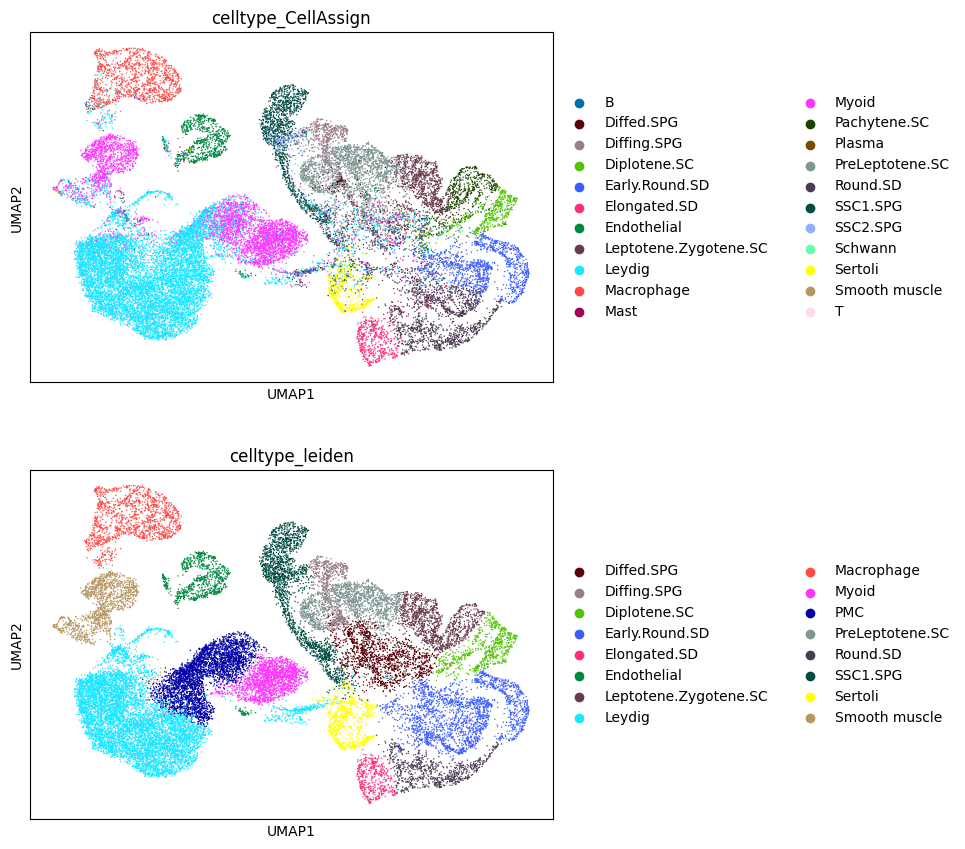

In [50]:
sc.pl.umap(bdata, color = ["celltype_CellAssign", "celltype_leiden"], ncols = 1)


In [51]:
os.getcwd()

'/faststorage/project/projectsInBioinformatics/workspaces/johan/PIB-johan-olesen/Notebooks'

In [60]:
#adata.obs["celltype_CellAssign"] = bdata.obs["celltype_CellAssign"]
bdata.obs["celltype_CellAssign"]

AAACCCAAGAGTAACT-1           SSC1.SPG
AAACCCAAGGTAGACC-1    PreLeptotene.SC
AAACCCAAGTAGGTTA-1        Diffing.SPG
AAACCCACATCATTTC-1           SSC1.SPG
AAACCCACATGAATCC-1              Myoid
                           ...       
TTTGTTGGTCGTGGAA-1        Diffing.SPG
TTTGTTGGTCTGTGGC-1        Diffing.SPG
TTTGTTGGTTCGGCTG-1              Myoid
TTTGTTGGTTGTCCCT-1       Diplotene.SC
TTTGTTGTCTACCACC-1     Early.Round.SD
Name: celltype_CellAssign, Length: 28719, dtype: category
Categories (22, object): ['B', 'Diffed.SPG', 'Diffing.SPG', 'Diplotene.SC', ..., 'Schwann', 'Sertoli', 'Smooth muscle', 'T']

In [62]:
bdata.write("../../results/celltype_annotation_scRNA.h5ad")